In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer

import tensorflow as tf

np.random.seed(208)

pd.options.display.max_columns = 100
%matplotlib inline
plt.style.use('seaborn')

/home/hardian_lawi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
radiant_cols = ['hero_' + str(i) for i in range(5)]
dire_cols = ['hero_' + str(i) for i in range(5, 10)]
no_heroes = 116

filter_cols = ['base_mr']

cont_variables = [
    'agi_gain',
    'attack_range',
    'attack_rate',
    'base_agi',
    'base_armor',
    'base_attack_max',
    'base_attack_min',
    'base_health_regen',
    'base_int',
    'base_mr',
    'base_str',
    'int_gain',
    'legs',
    'move_speed',
    'pro_ban',
    'pro_pick',
    'pro_win',
    'projectile_speed',
    'str_gain',
    'turn_rate',
]

unique_roles = [
    'Carry',
    'Disabler',
    'Durable',
    'Escape',
    'Initiator',
    'Jungler',
    'Nuker',
    'Pusher',
    'Support'
]

unique_primary_attrs = [
    'agi',
    'int',
    'str'
]

feature_names = cont_variables + \
    ['min_' + col for col in cont_variables if col not in filter_cols] + \
    ['max_' + col for col in cont_variables if col not in filter_cols] +  [
    'no_agi',
    'no_int',
    'no_str',
    'no_melees',
    'no_Carry',
    'no_Disabler',
    'no_Durable',
    'no_Escape',
    'no_Initiator',
    'no_Jungler',
    'no_Nuker',
    'no_Pusher',
    'no_Support',
]

def load_data():
    
    df = pd.read_csv('../data/matches_data.csv')
    radiants = pd.read_csv('../data/radiant_features.csv')
    dires = pd.read_csv('../data/dire_features.csv')
    
    assert np.all(radiants.columns == dires.columns), 'Radiants have different features than dires'
    assert df.shape[0] == radiants.shape[0], 'Number of matches in radiants are different to original matches data'
    assert df.shape[0] == dires.shape[0], 'Number of matches in dires are different to original matches data'
    assert len(feature_names) + 1 == radiants.shape[1]
    assert len(feature_names) + 1 == dires.shape[1]
    assert (radiants['match_id'] == dires['match_id']).all()
    assert (radiants['match_id'] == df['match_id']).all()
    
    radiants = radiants.\
        rename({col: 'radiant_' + col for col in feature_names}, axis=1).\
        drop('match_id', axis=1)
    dires = dires.\
        rename({col: 'dire_' + col for col in feature_names}, axis=1).\
        drop('match_id', axis=1)
    df = pd.concat([df[['match_id', 'radiant_win']], radiants, dires], axis=1)
    return radiants, dires, df

radiants, dires, df = load_data()

In [3]:
def define_model(name='custom_nn_1', optimizer='adam', seed=0, 
                 learning_rate=0.001, unit_size=16, activation='tanh'):
    
    tf.set_random_seed(seed)
    
    if optimizer == 'adam':
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(0.01)
    else:
        raise Exception
        
    x1 = tf.keras.layers.Input(shape=[len(feature_names)], name='input_radiant')
    x2 = tf.keras.layers.Input(shape=[len(feature_names)], name='input_dire')

    if name == 'nn_tanh':
        x = tf.keras.layers.Concatenate()([x1, x2])
        x = tf.keras.layers.Dense(unit_size, activation='tanh')(x)
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    elif name == 'nn_relu':
        x = tf.keras.layers.Concatenate()([x1, x2])
        x = tf.keras.layers.Dense(unit_size, activation='relu')(x)
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    elif name == 'custom_nn':
        dense = tf.keras.layers.Dense(unit_size // 2, activation=activation)
        x = tf.keras.layers.Concatenate()([dense(x1), dense(x2)])
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    elif name == 'custom_nn_l2_regularizer':
        dense = tf.keras.layers.Dense(unit_size // 2, activation=activation,
                                      kernel_regularizer=tf.keras.regularizers.l2(0.01))
        x = tf.keras.layers.Concatenate()([dense(x1), dense(x2)])
        x = tf.keras.layers.Dense(1, activation='sigmoid',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    elif name == 'custom_nn_dropout':
        dense = tf.keras.layers.Dense(unit_size // 2, activation=activation)
        x = tf.keras.layers.Concatenate()([dense(x1), dense(x2)])
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    elif name == 'nn_l2_regularizer':
        x = tf.keras.layers.Concatenate()([x1, x2])
        x = tf.keras.layers.Dense(unit_size, activation=activation, 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = tf.keras.layers.Dense(1, activation='sigmoid',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    elif name == 'nn_dropout':
        x = tf.keras.layers.Concatenate()([x1, x2])
        x = tf.keras.layers.Dropout(0.5, seed=seed)(x)
        x = tf.keras.layers.Dense(unit_size, activation=activation)(x)
        x = tf.keras.layers.Dropout(0.2, seed=seed)(x)
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    else:
        raise Exception
    
    model = tf.keras.Model(inputs=[x1, x2], outputs=x)
    model.compile(optimizer, loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [4]:
def train_and_pred(models, X_train, y_train, X_test, y_test, key):
    
    y_preds_train = 0
    y_preds_test = 0
    
    radiant_scaler = QuantileTransformer(output_distribution='normal')
    dire_scaler = QuantileTransformer(output_distribution='normal')
    
    X_train = [radiant_scaler.fit_transform(X_train[0]), dire_scaler.fit_transform(X_train[1])]
    X_test = [radiant_scaler.transform(X_test[0]), dire_scaler.transform(X_test[1])]
    
    for j, model in enumerate(models):

        history = model.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0)
        
        y_preds_train += model.predict(X_train)
        y_preds_test += model.predict(X_test)
        
    y_preds_train /= len(models)
    y_preds_test /= len(models)
    
    return y_preds_train, y_preds_test, history

In [5]:
batch_size = 128
epochs = 60

In [6]:
n_splits = 5
kf = KFold(n_splits, shuffle=True, random_state=10)

print('=================================================')

avg_score = {}
scores = {}
avg_threshold = 0

histories = {}

for i, (train_idx, test_idx) in enumerate(kf.split(df)):
    
    X_train = [radiants.iloc[train_idx].copy(), dires.iloc[train_idx].copy()]
    X_test = [radiants.iloc[test_idx].copy(), dires.iloc[test_idx].copy()]

    y_train = df.radiant_win.iloc[train_idx].values
    y_test = df.radiant_win.iloc[test_idx].values
    
    print('Iter', i)
    print('Train pos pctg', y_train.mean())
    print('Test pos pctg', y_test.mean())
    print('-------------------------------------------------\n')
    
    models_dict = {
        'custom_nn': [
            define_model(name='custom_nn', optimizer='adam', seed=0),
        ],
        'custom_nn_l2_regularizer': [
            define_model(name='custom_nn_l2_regularizer', optimizer='adam', seed=0),
        ],
        'custom_nn_dropout': [
            define_model(name='custom_nn_dropout', optimizer='adam', seed=0),
        ],
        'nn_tanh': [
            define_model(name='nn_tanh', optimizer='adam', seed=0),
        ],
        'nn_relu': [
            define_model(name='nn_relu', optimizer='adam', seed=0),
        ],
        'nn_l2_regularizer': [
            define_model(name='nn_l2_regularizer', optimizer='adam', seed=0),
        ],
        'nn_dropout': [
            define_model(name='nn_dropout', optimizer='adam', seed=0),
        ],
    }
    
    if i not in histories:
        histories[i] = {}
        
    scores[i] = {}
    
    for key, models in models_dict.items():
        
        if key not in avg_score:
            avg_score[key] = dict(train=0, test=0)
            
        if key not in histories[i]:
            histories[i][key] = {}
            
        temp_preds = train_and_pred(models, X_train, y_train, X_test, y_test, key)
        temp_scores = accuracy_score(y_train, temp_preds[0] > 0.5), \
            accuracy_score(y_test, temp_preds[1] > 0.5)
        
        avg_score[key]['train'] += temp_scores[0]
        avg_score[key]['test'] += temp_scores[1]
        
        scores[i][key] = temp_scores[1]

        print(key, '==', 
              'train: %.4f' % temp_scores[0], '-',
              'test: %.4f' % temp_scores[1])
        
        histories[i][key].update(temp_preds[2].history)

    print('=================================================\n')
          
############################################################################

print('Average score\n--------------------')
for key, models in models_dict.items():
    print(key, '=======', 
          'train:', avg_score[key]['train'] / n_splits, '----',
          'test:', avg_score[key]['test'] / n_splits)

Iter 0
Train pos pctg 0.5376726663876099
Test pos pctg 0.5424863959815822
-------------------------------------------------

Instructions for updating:
Colocations handled automatically by placer.
custom_nn == train: 0.5991 - test: 0.5633
custom_nn_l2_regularizer == train: 0.5739 - test: 0.5705
custom_nn_dropout == train: 0.5939 - test: 0.5719
nn_tanh == train: 0.6541 - test: 0.5502
nn_relu == train: 0.6429 - test: 0.5574
nn_l2_regularizer == train: 0.5755 - test: 0.5739
nn_dropout == train: 0.5776 - test: 0.5651

Iter 1
Train pos pctg 0.5393121250174411
Test pos pctg 0.5359285614622575
-------------------------------------------------

custom_nn == train: 0.5964 - test: 0.5670
custom_nn_l2_regularizer == train: 0.5730 - test: 0.5663
custom_nn_dropout == train: 0.5971 - test: 0.5757
nn_tanh == train: 0.6622 - test: 0.5470
nn_relu == train: 0.6443 - test: 0.5573
nn_l2_regularizer == train: 0.5760 - test: 0.5670
nn_dropout == train: 0.5777 - test: 0.5631

Iter 2
Train pos pctg 0.53781219

Text(0, 0.5, 'Validation Log loss')

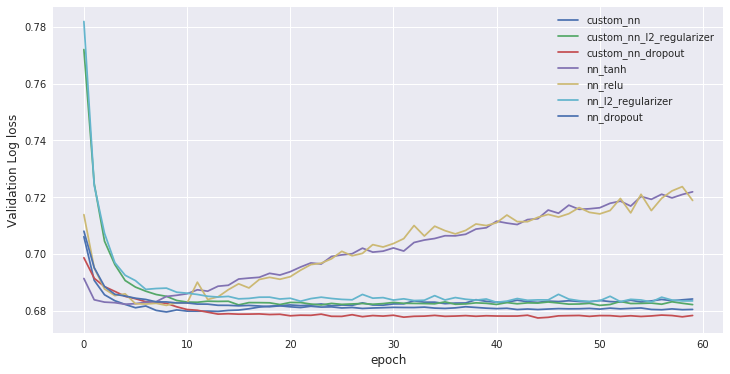

In [7]:
reform = {(metric, fold, model): values 
          for fold, interDict in histories.items() 
          for model, innerDict in interDict.items()
          for metric, values in innerDict.items()}

reform = pd.DataFrame(reform)

reform['val_loss'][0].plot(figsize=(12, 6))
plt.xlabel('epoch', fontsize=12)
plt.ylabel('Validation Log loss', fontsize=12)

## Find the optimal Learning Rate

Learning rate: 1e-05 

Average score
--------------------
custom_nn ======= train: 0.5254639319101437 ---- test: 0.5197711734337936
Learning rate: 5e-05 

Average score
--------------------
custom_nn ======= train: 0.5586298311706432 ---- test: 0.5436863401702247
Learning rate: 0.0001 

Average score
--------------------
custom_nn ======= train: 0.5761964559787917 ---- test: 0.5538440072554766
Learning rate: 0.0005 

Average score
--------------------
custom_nn ======= train: 0.5970140923677968 ---- test: 0.5655085809962328
Learning rate: 0.001 

Average score
--------------------
custom_nn ======= train: 0.6027208036835496 ---- test: 0.5612669178177759
Learning rate: 0.005 

Average score
--------------------
custom_nn ======= train: 0.6105902051067392 ---- test: 0.5624389563276125
Learning rate: 0.01 

Average score
--------------------
custom_nn ======= train: 0.6031812473838426 ---- test: 0.5563276126691782
Learning rate: 0.05 

Average score
--------------------
custom_nn ======= 

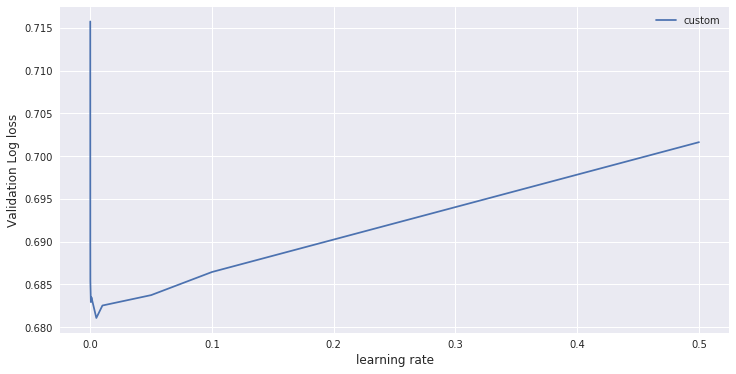

In [8]:
n_splits = 3
kf = KFold(n_splits, shuffle=True, random_state=10)

lrs = {}

lr_to_check = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.1, 0.5]

for learning_rate in lr_to_check:

    lrs[learning_rate] = {}

    avg_score = {}
    avg_threshold = 0

    print('=================================================')
    print('Learning rate:', learning_rate, '\n')

    for i, (train_idx, test_idx) in enumerate(kf.split(df)):

        X_train = [radiants.iloc[train_idx].copy(), dires.iloc[train_idx].copy()]
        X_test = [radiants.iloc[test_idx].copy(), dires.iloc[test_idx].copy()]

        y_train = df.radiant_win.iloc[train_idx].values
        y_test = df.radiant_win.iloc[test_idx].values

        models_dict = {
            'custom_nn': [
                define_model(name='custom_nn', optimizer='adam', 
                             seed=0, learning_rate=learning_rate),
            ],
        }

        if i not in lrs[learning_rate]:
            lrs[learning_rate][i] = {}

        for key, models in models_dict.items():

            if key not in avg_score:
                avg_score[key] = dict(train=0, test=0)

            temp_preds = train_and_pred(models, X_train, y_train, X_test, y_test, key)
            temp_scores = accuracy_score(y_train, temp_preds[0] > 0.5), \
                accuracy_score(y_test, temp_preds[1] > 0.5)

            avg_score[key]['train'] += temp_scores[0]
            avg_score[key]['test'] += temp_scores[1]

            lrs[learning_rate][i].update(temp_preds[2].history)

    ############################################################################

    print('Average score\n--------------------')
    for key, models in models_dict.items():
        print(key, '=======', 
              'train:', avg_score[key]['train'] / n_splits, '----',
              'test:', avg_score[key]['test'] / n_splits)

reform_1 = {(metric, lr, fold): values 
          for lr, interDict in lrs.items() 
          for fold, innerDict in interDict.items()
          for metric, values in innerDict.items()}

reform_1 = pd.DataFrame(reform_1)

temp = []
for lr in lr_to_check:
    temp.append(reform_1['val_loss'][lr].min(axis=0).mean())
print('Best learning rate:', lr_to_check[np.argmin(temp)], 'with loss', temp[np.argmin(temp)])

reform_1['val_loss'].min(axis=0).groupby(level=0).mean().plot(figsize=(12, 6))
plt.xlabel('learning rate', fontsize=12)
plt.ylabel('Validation Log loss', fontsize=12)
plt.legend(['custom'])

## Tune layer size

In [9]:
n_splits = 3
kf = KFold(n_splits, shuffle=True, random_state=10)

hs = {}

no_neurons = list(range(4, 36, 2))

for unit_size in no_neurons:
    
    hs[unit_size] = {}

    avg_score = {}
    avg_threshold = 0
    
    print('=================================================')
    print('Unit size:', unit_size, '\n')
    
    for i, (train_idx, test_idx) in enumerate(kf.split(df)):

        X_train = [radiants.iloc[train_idx].copy(), dires.iloc[train_idx].copy()]
        X_test = [radiants.iloc[test_idx].copy(), dires.iloc[test_idx].copy()]

        y_train = df.radiant_win.iloc[train_idx].values
        y_test = df.radiant_win.iloc[test_idx].values

        models_dict = {
            'custom_nn': [
                define_model(name='custom_nn', optimizer='adam', 
                             seed=0, unit_size=unit_size),
            ],
        }

        if i not in hs[unit_size]:
            hs[unit_size][i] = {}

        for key, models in models_dict.items():

            if key not in avg_score:
                avg_score[key] = dict(train=0, test=0)

            temp_preds = train_and_pred(models, X_train, y_train, X_test, y_test, key)
            temp_scores = accuracy_score(y_train, temp_preds[0] > 0.5), \
                accuracy_score(y_test, temp_preds[1] > 0.5)

            avg_score[key]['train'] += temp_scores[0]
            avg_score[key]['test'] += temp_scores[1]

            hs[unit_size][i].update(temp_preds[2].history)

    ############################################################################

    print('Average score\n--------------------')
    for key, models in models_dict.items():
        print(key, '=======', 
              'train:', avg_score[key]['train'] / n_splits, '----',
              'test:', avg_score[key]['test'] / n_splits)
        

Unit size: 4 

Average score
--------------------
custom_nn ======= train: 0.5779545137435468 ---- test: 0.563945862983117
Unit size: 6 

Average score
--------------------
custom_nn ======= train: 0.5872610576252267 ---- test: 0.5711734337937769
Unit size: 8 

Average score
--------------------
custom_nn ======= train: 0.5910980884610018 ---- test: 0.5689688851681317
Unit size: 10 

Average score
--------------------
custom_nn ======= train: 0.5944467699176782 ---- test: 0.5675177898702386
Unit size: 12 

Average score
--------------------
custom_nn ======= train: 0.5963164503976559 ---- test: 0.5638342402678945
Unit size: 14 

Average score
--------------------
custom_nn ======= train: 0.5998744244453746 ---- test: 0.5631365982977536
Unit size: 16 

Average score
--------------------
custom_nn ======= train: 0.6035719268871215 ---- test: 0.5627459187944747
Unit size: 18 

Average score
--------------------
custom_nn ======= train: 0.6100181386912237 ---- test: 0.5572764057485698
Unit

In [10]:
reform_2 = {(metric, unit_size, fold): values 
          for unit_size, interDict in hs.items() 
          for fold, innerDict in interDict.items()
          for metric, values in innerDict.items()}

reform_2 = pd.DataFrame(reform_2)

In [11]:
temp = []
for unit_size in no_neurons:
    temp.append(reform_2['val_loss'][unit_size].min(axis=0).mean())
print('Best unit size:', no_neurons[np.argmin(temp)], 'with loss', temp[np.argmin(temp)])

Best unit size: 6 with loss 0.6796803533556872


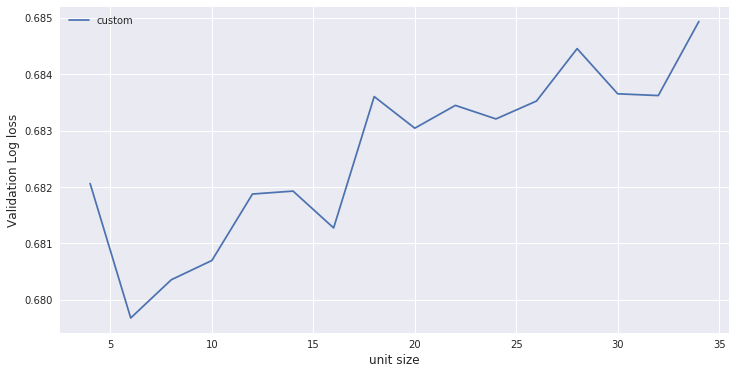

In [12]:
reform_2['val_loss'].min(axis=0).groupby(level=0).mean().plot(figsize=(12, 6))
plt.xlabel('unit size', fontsize=12)
plt.ylabel('Validation Log loss', fontsize=12)
plt.legend(['custom'])

## Calculate best accuracy

In [13]:
learning_rate = 0.005
unit_size = 18

n_splits = 5
kf = KFold(n_splits, shuffle=True, random_state=10)

print('=================================================')

avg_score = {}
scores = {}
avg_threshold = 0

histories = {}

for i, (train_idx, test_idx) in enumerate(kf.split(df)):
    
    X_train = [radiants.iloc[train_idx].copy(), dires.iloc[train_idx].copy()]
    X_test = [radiants.iloc[test_idx].copy(), dires.iloc[test_idx].copy()]

    y_train = df.radiant_win.iloc[train_idx].values
    y_test = df.radiant_win.iloc[test_idx].values
    
    print('Iter', i)
    print('Train pos pctg', y_train.mean())
    print('Test pos pctg', y_test.mean())
    print('-------------------------------------------------\n')
    
    models_dict = {
        'custom_nn': [
            define_model(name='custom_nn', optimizer='adam', seed=0),
        ],
        'custom_nn_l2_regularizer': [
            define_model(name='custom_nn_l2_regularizer', optimizer='adam', seed=0),
        ],
        'custom_nn_dropout': [
            define_model(name='custom_nn_dropout', optimizer='adam', seed=0),
        ],
        'nn_l2_regularizer': [
            define_model(name='nn_l2_regularizer', optimizer='adam', seed=0),
        ],
        'nn_dropout': [
            define_model(name='nn_dropout', optimizer='adam', seed=0),
        ],
    }
    
    if i not in histories:
        histories[i] = {}
        
    scores[i] = {}
    
    for key, models in models_dict.items():
        
        if key not in avg_score:
            avg_score[key] = dict(train=0, test=0)
            
        if key not in histories[i]:
            histories[i][key] = {}
            
        temp_preds = train_and_pred(models, X_train, y_train, X_test, y_test, key)
        temp_scores = accuracy_score(y_train, temp_preds[0] > 0.5), \
            accuracy_score(y_test, temp_preds[1] > 0.5)
        
        avg_score[key]['train'] += temp_scores[0]
        avg_score[key]['test'] += temp_scores[1]
        
        scores[i][key] = temp_scores[1]

        print(key, '==', 
              'train: %.4f' % temp_scores[0], '-',
              'test: %.4f' % temp_scores[1])
        
        histories[i][key].update(temp_preds[2].history)

    print('=================================================\n')
          
############################################################################

print('Average score\n--------------------')
for key, models in models_dict.items():
    print(key, '=======', 
          'train:', avg_score[key]['train'] / n_splits, '----',
          'test:', avg_score[key]['test'] / n_splits)

Iter 0
Train pos pctg 0.5376726663876099
Test pos pctg 0.5424863959815822
-------------------------------------------------

custom_nn == train: 0.5966 - test: 0.5670
custom_nn_l2_regularizer == train: 0.5740 - test: 0.5661
custom_nn_dropout == train: 0.5944 - test: 0.5774
nn_dropout == train: 0.5731 - test: 0.5644

Iter 1
Train pos pctg 0.5393121250174411
Test pos pctg 0.5359285614622575
-------------------------------------------------

custom_nn == train: 0.6050 - test: 0.5620
custom_nn_l2_regularizer == train: 0.5714 - test: 0.5619
custom_nn_dropout == train: 0.5947 - test: 0.5758
nn_l2_regularizer == train: 0.5722 - test: 0.5645
nn_dropout == train: 0.5776 - test: 0.5659

Iter 2
Train pos pctg 0.5378121947816381
Test pos pctg 0.5419282824054695
-------------------------------------------------

custom_nn == train: 0.6014 - test: 0.5648
custom_nn_l2_regularizer == train: 0.5729 - test: 0.5683
custom_nn_dropout == train: 0.5963 - test: 0.5648
nn_l2_regularizer == train: 0.5777 - tes

In [14]:
reform_3 = {(metric, fold, model): values 
          for fold, interDict in histories.items() 
          for model, innerDict in interDict.items()
          for metric, values in innerDict.items()}

reform_3 = pd.DataFrame(reform_3)

In [15]:
reform_3['val_acc'].max(axis=0).groupby(level=1).mean()

custom_nn                   0.568271
custom_nn_dropout           0.576476
custom_nn_l2_regularizer    0.575136
nn_dropout                  0.570001
nn_l2_regularizer           0.571062
dtype: float64

Text(0, 0.5, 'Validation Accuracy')

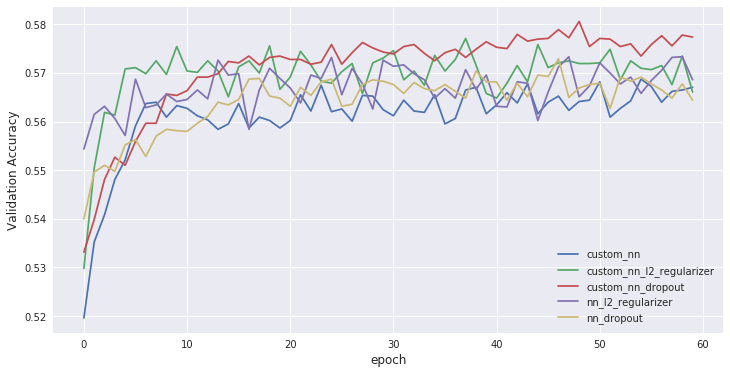

In [16]:
reform_3['val_acc'][0].plot(figsize=(12, 6))
plt.xlabel('epoch', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)